В данном нотбуке будем решать задачу одноклассовой семантической сегментации, необходимо будет сегментировать штрихкоды на картинках.

In [1]:
# Загрузка данных
%%capture
!unzip "/content/drive/MyDrive/data_segmentation.zip"

In [2]:
!ls ./data

annotations.tsv  images  README.md


В папке _images_ лежат собранные на Толоке фотографии со
штрих-кодами.

В файле _annotations.tsv_ лежит разметка этих изображений. В ней указаны:

- **filename** - относительный путь до изображения (вида images/<filename>), к которому относится аннотация.
- **code** - код штрих-кода, находящегося внутри ограничивающего бокса.
- **x_from** - минимальная координата ограничивающего бокса по оси x.
- **y_from** - минимальная координата ограничивающего бокса по оси y.
- **width** - ширина ограничивающего бокса.
- **height** - высота ограничивающего бокса.

Размеры изображений: width/height  1000/1333

# Подготовка

In [3]:
%%capture
!pip install pytorch_lightning segmentation_models_pytorch torchmetrics

In [4]:
import pandas as pd
import numpy as np

import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader,Dataset, random_split
import torchmetrics

from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt

import random

In [5]:
random.seed(69)
torch.manual_seed(69)
np.random.seed(69)

In [6]:
cuda = torch.cuda.is_available()
cuda

True

In [7]:
df = pd.read_csv('./data/annotations.tsv', sep='\t')

In [8]:
df = df.drop('code', axis=1)
df.head()

filename  x_from  y_from  width  \
0  images/c234c76c-d72d-4d60-8066-e99f62361c1c--r...     210     542    279   
1  images/0b56af7e-386c-410a-8f46-74350f755d77--r...     216     474    409   
2  images/77c7bd8d-bb64-4c4b-94c5-798a903eaa4d--r...     173     657    589   
3  images/5d60b81b-e31d-4530-bed1-27a8872d1f02--r...      66     665    549   
4  images/bb225480-a447-4232-85ab-ce22f1dec070--r...     269     592    448   

   height  
0     143  
1     308  
2     293  
3     176  
4     247

In [9]:
!ls data

annotations.tsv  images  README.md


Взглянем на картинки и их маски

In [10]:
def create_mask(row, image_size):
    mask = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(mask)
    x, y, width, height = row['x_from'], row['y_from'], row['width'], row['height']
    draw.rectangle([x, y, x + width, y + height], fill=255)
    return mask

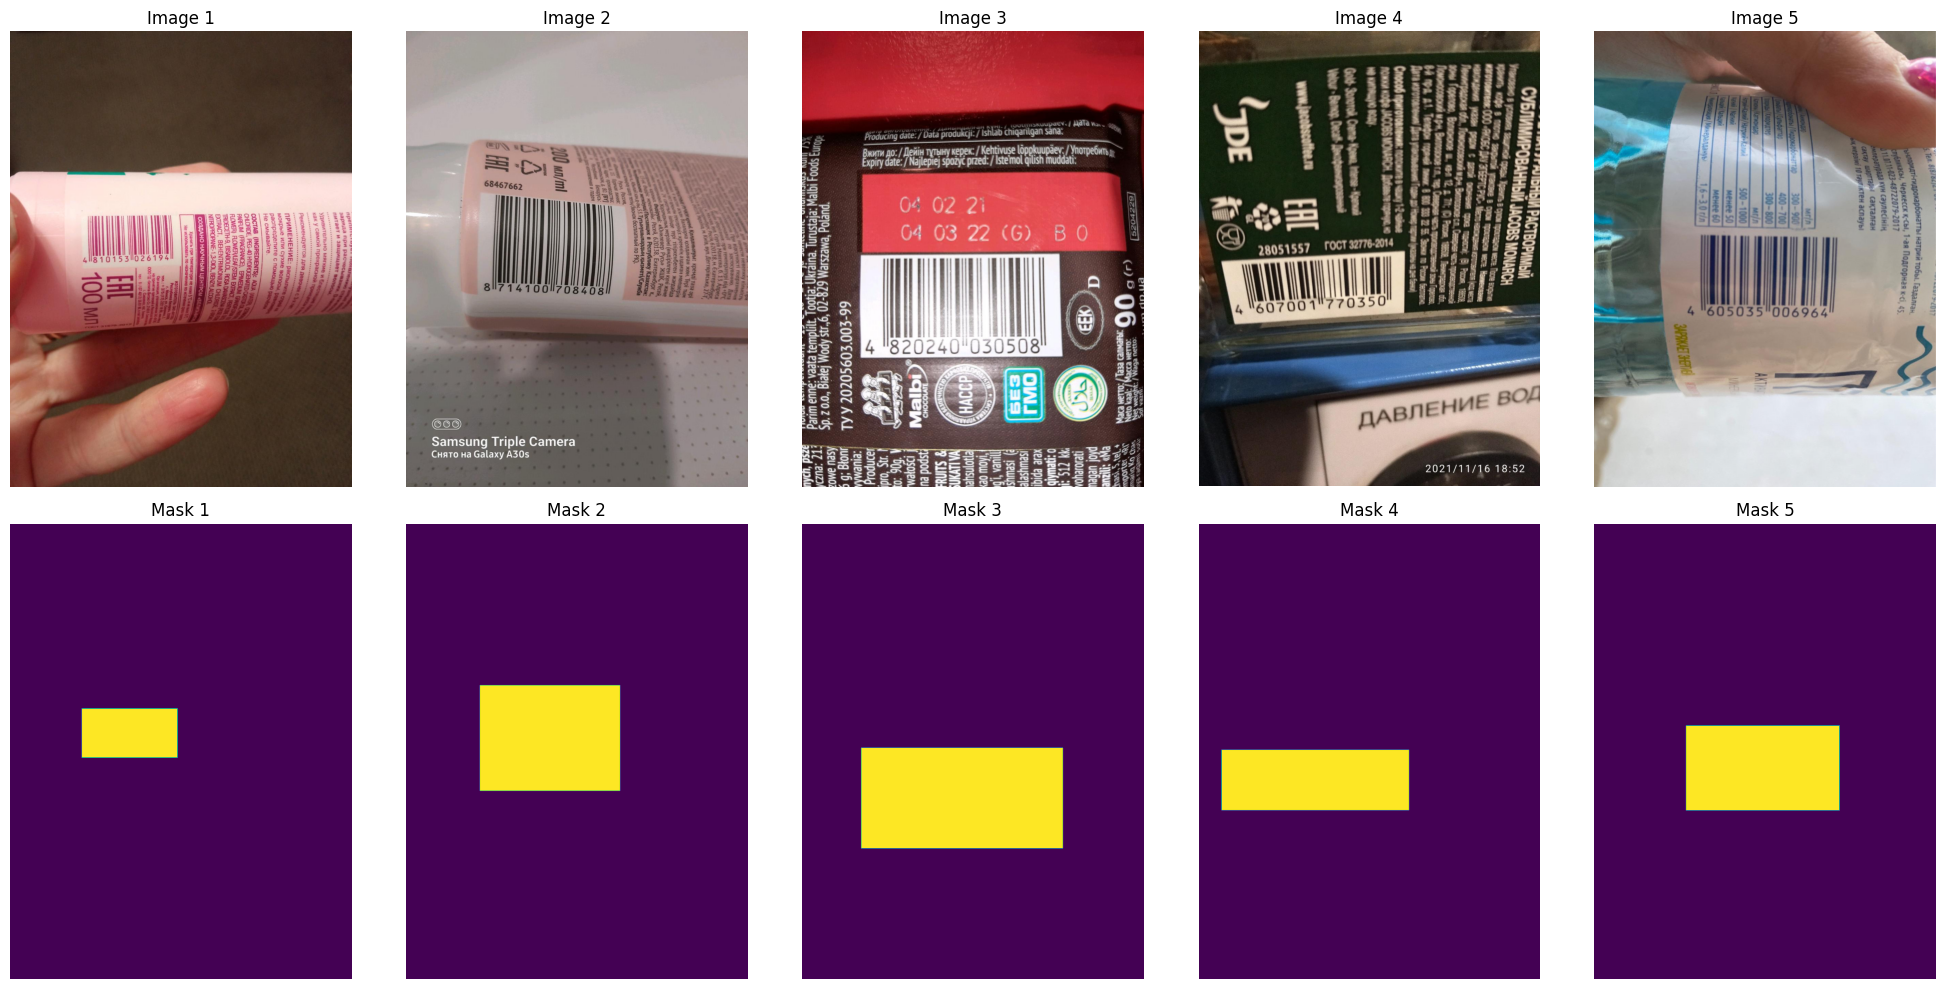

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i in range(5):
    row = df.iloc[i]
    image_path = './data/' + row['filename']
    image = Image.open(image_path)
    mask = create_mask(row, image.size)

    axes[0, i].imshow(image)
    axes[0, i].set_title(f'Image {i + 1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(mask)
    axes[1, i].set_title(f'Mask {i + 1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Подготовим папку с масками

In [12]:
image_dir = './data/images'
mask_dir = './data/masks'

if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)

In [13]:
def create_mask_images(row, image_size, mask_path):
    mask = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(mask)
    x, y, width, height = row['x_from'], row['y_from'], row['width'], row['height']
    draw.rectangle([x, y, x + width, y + height], fill=255)
    mask.save(mask_path)

расположим бинарные маски в ./data/masks


In [14]:
for _, row in df.iterrows():
    image_path = os.path.join('./data', row['filename'].lstrip('/'))
    mask_path = os.path.join(mask_dir, os.path.basename(row['filename']).replace(".jpg", "_mask.png"))
    image = Image.open(image_path)
    create_mask_images(row, image.size, mask_path)

# Dataset | DataModule

In [15]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_file_name = self.images[idx].replace('.jpg', '_mask.png')
        mask_path = os.path.join(self.mask_dir, mask_file_name)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transform is not None:
            image = self.image_transform(image)

        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return image, mask

In [16]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
resize_dim = 512

image_transform = Compose([
    Resize((resize_dim, resize_dim)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = Compose([
    Resize((resize_dim, resize_dim), interpolation=Image.NEAREST),
    ToTensor()
])

In [17]:
class MyDataModule(pl.LightningDataModule):
    def __init__(self, dataset, batch_size, test_split, random_seed=None):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.test_split = test_split
        random.seed(random_seed)
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)

    def setup(self, stage=None):
        train_size = int((1 - self.test_split) * len(self.dataset))
        test_size = len(self.dataset) - train_size
        self.train_dataset, self.test_dataset = random_split(self.dataset, [train_size, test_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

# Model

In [18]:
class SegmentationModel(pl.LightningModule):
    def __init__(self, model, optimizer_class, optimizer_params, loss_func):
        super().__init__()
        self.model = model
        self.optimizer_class = optimizer_class
        self.optimizer_params = optimizer_params
        self.loss_func = loss_func
        self.iou_metric = torchmetrics.JaccardIndex(num_classes=1, task='binary')
        self.dice_metric = torchmetrics.Dice(num_classes=1,  multiclass=False)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        masks_float = masks.float()  # For loss calculation
        masks_pred = self(images)
        loss = self.loss_func(masks_pred, masks_float)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True)

        # For metrics calculation
        masks_pred_sigmoid = torch.sigmoid(masks_pred)
        masks_pred_bin = (masks_pred_sigmoid > 0.5).int()
        masks_int = masks.int()  # Convert masks to integer for metrics
        iou = self.iou_metric(masks_pred_bin, masks_int)
        dice = self.dice_metric(masks_pred_bin, masks_int)
        self.log('train_iou', iou,on_epoch=True, logger=True)
        self.log('train_dice', dice, on_epoch=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        masks_float = masks.float()  # For loss calculation
        masks_pred = self(images)
        loss = self.loss_func(masks_pred, masks_float)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)

        masks_pred_sigmoid = torch.sigmoid(masks_pred)
        masks_pred_bin = (masks_pred_sigmoid > 0.5).int()
        masks_int = masks.int()  # Convert masks to integer for metrics
        iou = self.iou_metric(masks_pred_bin, masks_int)
        dice = self.dice_metric(masks_pred_bin, masks_int)
        self.log('val_iou', iou, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_dice', dice, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        return self.optimizer_class(self.parameters(), **self.optimizer_params)

# Expriment 1

In [19]:
image_paths = './data/images/'
mask_paths = './data/masks/'

dataset = SegmentationDataset(image_paths, mask_paths, image_transform, mask_transform)

In [20]:
segmentation_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

optimizer_params = {"lr": 1e-3, "weight_decay": 1e-5}

model = SegmentationModel(
    model=segmentation_model,
    optimizer_class=torch.optim.Adam,
    optimizer_params=optimizer_params,
    loss_func=torch.nn.BCEWithLogitsLoss()
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 269MB/s]


In [21]:
data_module = MyDataModule(dataset, batch_size=10, test_split=0.01, random_seed=69)
trainer = pl.Trainer(max_epochs=30, accelerator='cuda')
trainer.fit(model, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params
---------------------------------------------------
0 | model       | Unet               | 24.4 M
1 | loss_func   | BCEWithLogitsLoss  | 0     
2 | iou_metric  | BinaryJaccardIndex | 0     
3 | dice_metric | Dice               | 0     
---------------------------------------------------
24.4 M    Trainable params
0     

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Взглянем на маски обученной модели

In [23]:
def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=tensor.device).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=tensor.device).view(-1, 1, 1)
    tensor = tensor * std + mean
    return tensor.clamp(0, 1)

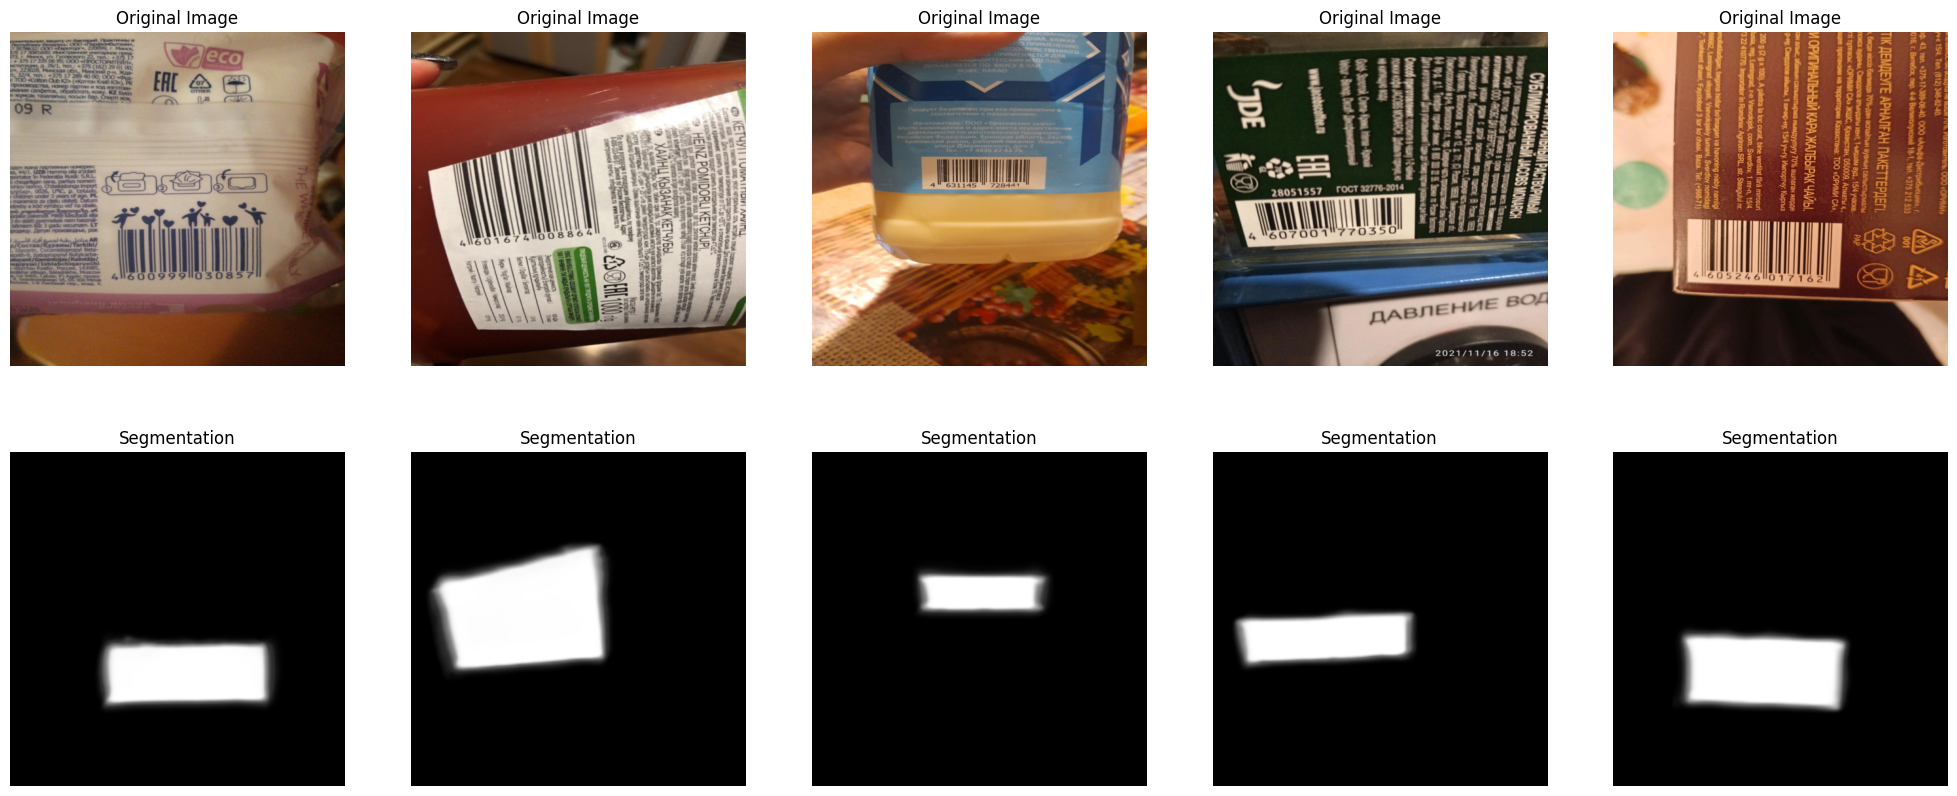

In [24]:
test_loader = data_module.test_dataloader()

model.eval()
model.to('cuda' if torch.cuda.is_available() else 'cpu')
images = next(iter(test_loader))[0][:5]

with torch.no_grad():
    images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
    predictions = model(images)

# Визуализация
fig, axs = plt.subplots(2, 5, figsize=(25, 10))
for i in range(5):
    original_img = unnormalize(images[i]).cpu()
    axs[0, i].imshow(to_pil_image(original_img))
    axs[0, i].set_title("Original Image")
    axs[0, i].axis('off')

    axs[1, i].imshow(to_pil_image(torch.sigmoid(predictions[i]).cpu()), cmap="gray")
    axs[1, i].set_title("Segmentation")
    axs[1, i].axis('off')

plt.show()

In [25]:
from tensorboard.backend.event_processing import event_accumulator

def load_tensorboard_logs(logdir):
    # Создание аккумулятора для чтения данных
    ea = event_accumulator.EventAccumulator(logdir,
        size_guidance={event_accumulator.SCALARS: 0})
    ea.Reload()

    # Извлекаем скалярные данные (например, потери и метрики)
    data = {}
    for tag in ea.Tags()['scalars']:
        events = ea.Scalars(tag)
        data[tag] = [event.value for event in events]
    return data

In [ ]:
logdir = '/content/lightning_logs/version_0/events.out.tfevents.1705951585.8495c59ec4d7.504.0'
data = load_tensorboard_logs(logdir)

Loss | Metric

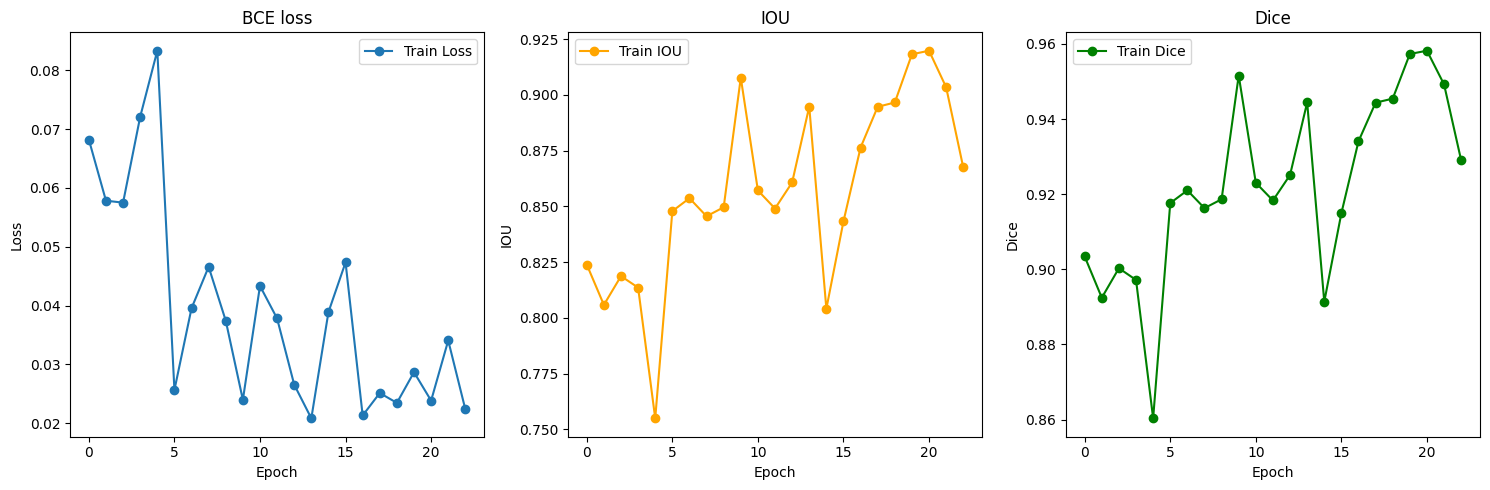

In [28]:
plt.figure(figsize=(15, 5))

# Subplot for loss per step
plt.subplot(1, 3, 1)
plt.plot(data['train_loss_step'], label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BCE loss')
plt.legend()

# Subplot for IOU per step
plt.subplot(1, 3, 2)
plt.plot(data['train_iou_step'], label='Train IOU', marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.title('IOU')
plt.legend()

# Subplot for Dice per step
plt.subplot(1, 3, 3)
plt.plot(data['train_dice_step'], label='Train Dice', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Dice')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Experiment 2

In [31]:
segmentation_model_2 = smp.DeepLabV3(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

optimizer_params = {"lr": 1e-3, "weight_decay": 1e-5}

model = SegmentationModel(
    model=segmentation_model_2,
    optimizer_class=torch.optim.Adam,
    optimizer_params=optimizer_params,
    loss_func=torch.nn.BCEWithLogitsLoss()
)

In [32]:
data_module = MyDataModule(dataset, batch_size=10, test_split=0.01, random_seed=69)
trainer = pl.Trainer(max_epochs=20, accelerator='cuda')
trainer.fit(model, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params
---------------------------------------------------
0 | model       | DeepLabV3          | 26.0 M
1 | loss_func   | BCEWithLogitsLoss  | 0     
2 | iou_metric  | BinaryJaccardIndex | 0     
3 | dice_metric | Dice               | 0     
---------------------------------------------------
26.0 M    Trainable params
0     

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


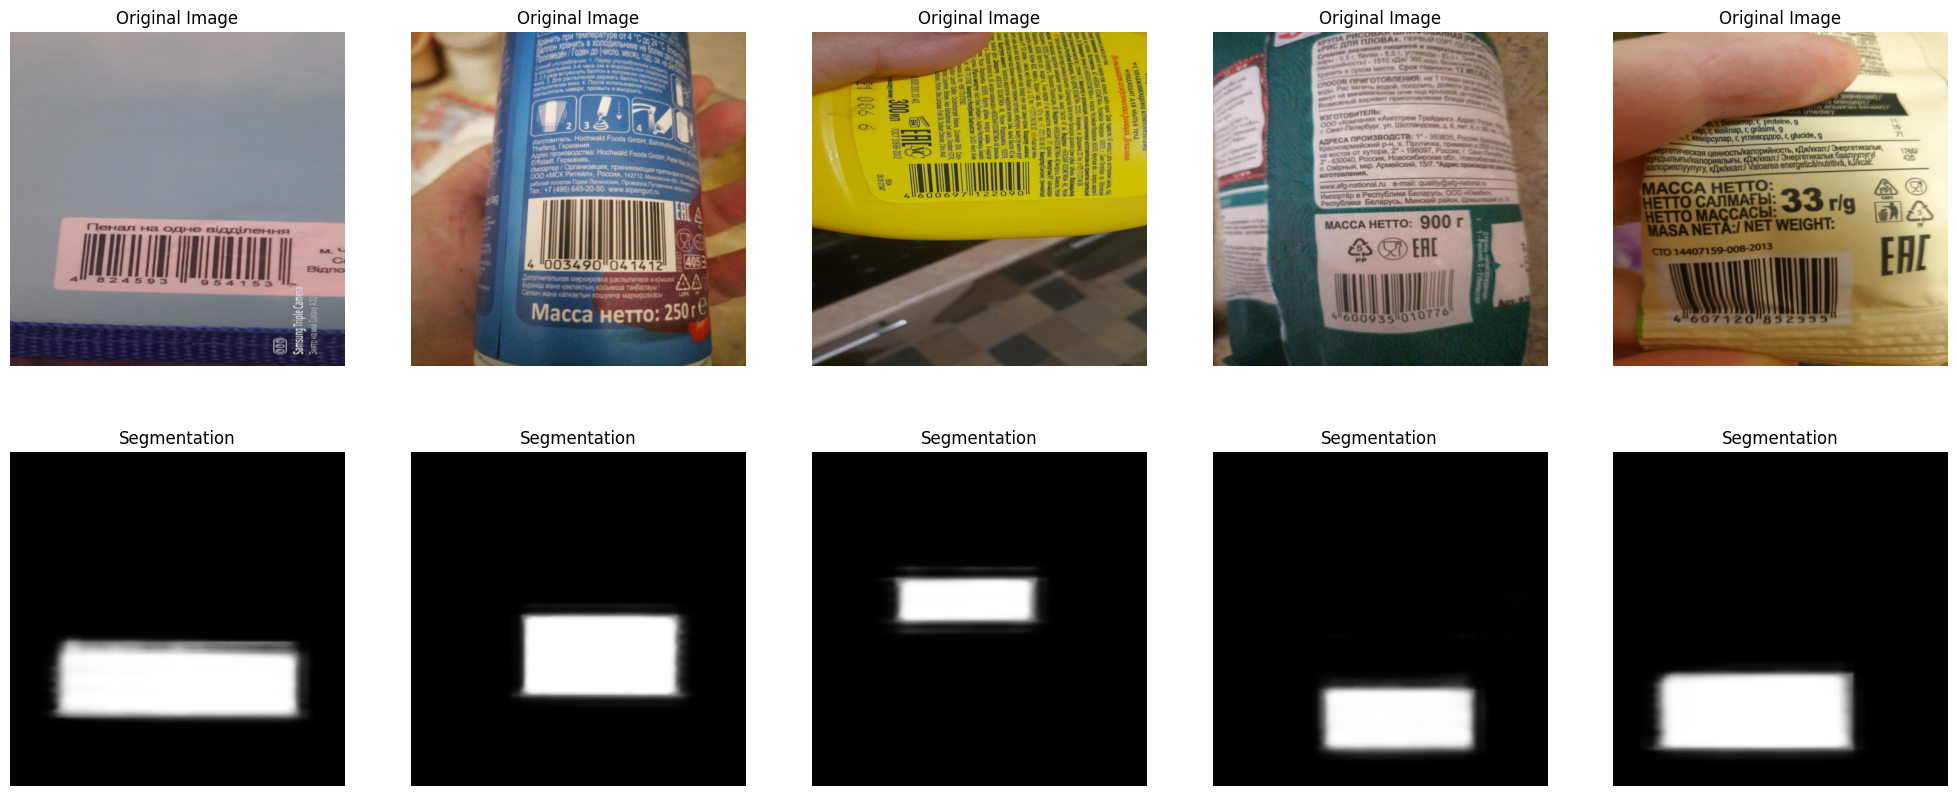

In [36]:
test_loader = data_module.test_dataloader()

model.eval()
model.to('cuda' if torch.cuda.is_available() else 'cpu')
images = next(iter(test_loader))[0][:5]

with torch.no_grad():
    images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
    predictions = model(images)

# Визуализация
fig, axs = plt.subplots(2, 5, figsize=(25, 10))
for i in range(5):
    original_img = unnormalize(images[i]).cpu()
    axs[0, i].imshow(to_pil_image(original_img))
    axs[0, i].set_title("Original Image")
    axs[0, i].axis('off')

    axs[1, i].imshow(to_pil_image(torch.sigmoid(predictions[i]).cpu()), cmap="gray")
    axs[1, i].set_title("Segmentation")
    axs[1, i].axis('off')

plt.show()

Loss | Metrics

In [34]:
logdir = '/content/lightning_logs/version_1/events.out.tfevents.1705953329.8495c59ec4d7.504.1'
loss_epx2 = load_tensorboard_logs(logdir)

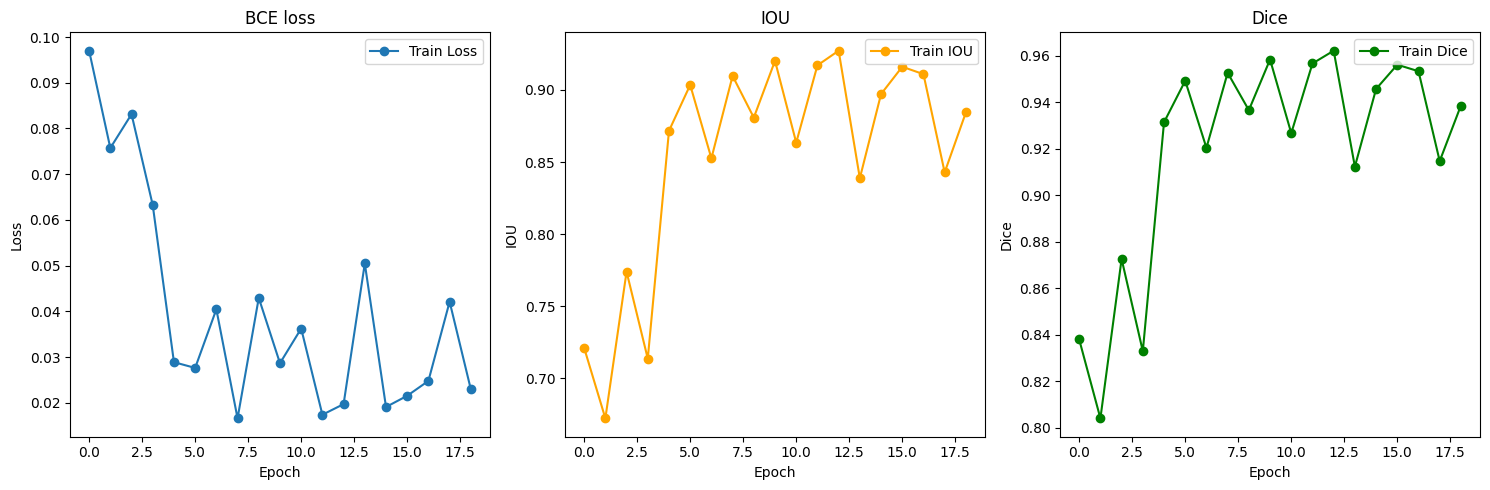

In [35]:
plt.figure(figsize=(15, 5))

# Subplot for loss
plt.subplot(1, 3, 1)
plt.plot(loss_epx2['train_loss_step'], label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BCE loss')
plt.legend()

# Subplot for IOU
plt.subplot(1, 3, 2)
plt.plot(loss_epx2['train_iou_step'], label='Train IOU', marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.title('IOU')
plt.legend()

# Subplot for Dice
plt.subplot(1, 3, 3)
plt.plot(loss_epx2['train_dice_step'], label='Train Dice', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Dice')
plt.legend()

plt.tight_layout()
plt.show()